In [1]:
import numpy as np
import scipy.linalg as scila
import numpy.linalg as la
from qiskit.quantum_info import Operator

from qiskit import QuantumCircuit


I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

H = 1/np.sqrt(2) * np.array([[1,1],[1,-1]])       #X->Z, Y->-Y, Z->X
S = np.array([[1,0],[0,1j]])                      #X->Y, Y->-X, Z->Z
Sdag = np.array([[1,0],[0,-1j]])

CX = np.kron((I+Z)/2,I) + np.kron((I-Z)/2,X)


def pstring_to_matrix(pstring):
    
    result = 1
    for p in pstring:
        if p == '-':
            result = np.kron(I,result)
        elif p == 'X':
            result = np.kron(X,result)
        elif p == 'Y':
            result = np.kron(Y,result)
        elif p == 'Z':
            result = np.kron(Z,result)
    return result


In [2]:
# -: identity, X,Y,Z: Pauli matrices

def h(pstring, index):
    
    result = pstring.copy()
    signchange = False
    
    if pstring[index] == 'X':
        result[index] = 'Z'
    elif pstring[index] == 'Y':
        signchange = True
    elif pstring[index] == 'Z':
        result[index] = 'X'
        
    return result, signchange

def s(pstring, index):
    result = pstring.copy()
    signchange = False
    
    if pstring[index] == 'X':
        result[index] = 'Y'
    elif pstring[index] == 'Y':
        result[index] = 'X'
        signchange = True
        
    return result, signchange

def sdag(pstring, index):
    result = pstring.copy()
    signchange = False
    
    if pstring[index] == 'X':
        result[index] = 'Y'
        signchange = True
    elif pstring[index] == 'Y':
        result[index] = 'X'
        
    return result, signchange


def cx(pstring, i1, i2):
    result = pstring.copy()
    signchange = False
    
    p1 = pstring[i1]
    p2 = pstring[i2]
    
    if p1 == '-' and (p2 == 'Z' or p2 == 'Y'):
        result[i1] = 'Z'
    elif p1 == 'Z' and (p2 == 'Z' or p2 == 'Y'):
        result[i1] = '-'
    elif p1 == 'X' and p2 == '-' :
        result[i2] = 'X'
    elif p1 == 'X' and p2 == 'X' :
        result[i2] = '-'
    elif p1 == 'X' and p2 == 'Y' :
        result[i1] = 'Y'
        result[i2] = 'Z'
    elif p1 == 'X' and p2 == 'Z' :
        result[i1] = 'Y'
        result[i2] = 'Y'
        signchange = True
    elif p1 == 'Y' and p2 == '-' :
        result[i2] = 'X'
    elif p1 == 'Y' and p2 == 'X' :
        result[i2] = '-'
    elif p1 == 'Y' and p2 == 'Y' :
        result[i1] = 'X'
        result[i2] = 'Z'
        signchange = True
    elif p1 == 'Y' and p2 == 'Z' :
        result[i1] = 'X'
        result[i2] = 'Y'
        
    return result, signchange

def diag_w_1q(pstring, n):
    ops = []
    for i in range(n):
        s = pstring[i]
        if s == 'X':
            ops.append(['H', i])
        elif s == 'Y':
            ops.append(['Sdag', i])
            ops.append(['H', i])
            
    return ops


def localize_diagonal(pstring, n):
    indices = []
    for i in range(n):
        if pstring[i] != '-':
            indices.append(i)
            
    if len(indices)<2:
        return []
            
    ops = []
    for i in range(len(indices)-1):
        # ops.append(['CX', indices[i], indices[-1]])
        ops.append(['CX', indices[i], indices[i+1]])
     
    return ops
    
#     if ops == []:
#         return ops, n
#     else:
#         return ops, indices[-1]

def local_diagonalize(pstring, n):
    
    ops1 = diag_w_1q(pstring,n)
    ops2 = localize_diagonal(pstring, n) 

    
    return  ops1 + ops2

def sort_pstrings(pstrings):
    vals = np.zeros(len(pstrings))
    
    for ip, p in enumerate(pstrings):
        for j in range(len(p)-1,-1,-1):
            if p[j] != '-':
                vals[ip] = -j
                break
                
    indices = np.argsort(vals)
    
#     print(vals)
#     print(indices)
    
    result = []
    for i in indices:
        result.append(pstrings[i])
        
    return result


def get_right_most(pstrings,current_qubit):
    #print('get_right_most\t', current_qubit)
    vals = -np.ones(len(pstrings),dtype = int)
    
    for ip, p in enumerate(pstrings):
        for j in range(current_qubit,-1,-1):
            if p[j] != '-':
                vals[ip] = j
                break
#     print('-'*20)
#     for i in range(len(pstrings)):
#         print(pstrings[i],'\t',vals[i])
#     print('-'*20)
    # print('-----')
    # print(pstrings)
    # print(vals)
    # print('-----')
    result_index = np.argmax(vals)
    return result_index, vals[result_index]


# XIIXYZI     5
# XIIXIZI     3

def simultaneously_diagonalize(old_pstringlist, barrier = False):
    #assume that the list is somehow sorted
    ops = []
    
    n = len(old_pstringlist[0])
    
    pstringlist = old_pstringlist.copy()

    current_qubit = n-1
    
    for i in range(len(pstringlist)):
        
        index, current_qubit = get_right_most(pstringlist,current_qubit)
        new_ops = local_diagonalize(pstringlist[index], current_qubit+1)
        current_qubit += -1

        if barrier:
            ops = ops + new_ops + [['Barr']]
        else:
            ops = ops + new_ops
        
        # ops = ops + new_ops
        
        for j in range(len(pstringlist)):
            pstringlist[j], change = apply_ops(new_ops, pstringlist[j]) 
        
#         print(i, len(pstringlist), n)
#         print(new_ops)
#         for p in pstringlist:
#             print(p)
        
    return ops

def simultaneously_diagonalize_circuit(old_pstringlist, barrier = False):
    #assume that the list is somehow sorted
    ops = []
    
    n = len(old_pstringlist[0])
    
    qc = QuantumCircuit(n)
    current_qubit = n-1
    
    pstringlist = old_pstringlist.copy()
    
    for i in range(len(pstringlist)):
        index, current_qubit = get_right_most(pstringlist,current_qubit)
        new_ops = local_diagonalize(pstringlist[index], current_qubit+1)
        current_qubit += -1

        if barrier:
            ops = ops + new_ops + [['Barr']]
        else:
            ops = ops + new_ops
        
        for j in range(len(pstringlist)):
            pstringlist[j], change = apply_ops(new_ops, pstringlist[j]) 
        
        # print(i, len(pstringlist), n)
        # print(new_ops)
        # for p in pstringlist:
        #     print(p)
        # new_ops, n = local_diagonalize(pstringlist[index], n)
        # #new_ops, n = local_diagonalize(pstringlist[i], n)

        # if barrier:
        #     ops = ops + new_ops + [['Barr']]
        # else:
        #     ops = ops + new_ops
        
        # for j in range(len(pstringlist)):
        #     pstringlist[j], change = apply_ops(new_ops, pstringlist[j]) 
        
        # print(i, len(pstringlist), n)
        # print(new_ops)
        # for p in pstringlist:
            # print(p)
    
    for i in range(len(ops)-1,-1,-1):
        o = ops[i]
        if o[0] == 'H':
            qc.h(o[1])
        elif o[0] == 'S':
            qc.sdg(o[1])
        elif o[0] == 'Sdag':
            qc.s(o[1])
        elif o[0] == 'CX':
            qc.cx(o[1],o[2])
        elif o[0] == 'Barr':
            qc.barrier()
    return qc
    

    
def apply_ops(ops, pstring):
    
    signchange = False
    result = pstring.copy()
    
    for o in ops:
        
        change = False
        if o[0] == 'H':
            result, change = h(result, o[1])
        elif o[0] == 'S':
            result, change = s(result, o[1])
        elif o[0] == 'Sdag':
            result, change = sdag(result, o[1])
        elif o[0] == 'CX':
            result, change = cx(result, o[1], o[2])
            
        if change:
            signchange = not signchange
    
    return result, signchange

def ops_to_circuit(operation_list, n, barrier = False):

    qc = QuantumCircuit(n)
    for i in range(len(ops)-1,-1,-1):
        o = ops[i]
        if o[0] == 'H':
            qc.h(o[1])
        elif o[0] == 'S':
            qc.sdg(o[1])
        elif o[0] == 'Sdag':
            qc.s(o[1])
        elif o[0] == 'CX':
            qc.cx(o[1],o[2])
        elif o[0] == 'Barr' and barrier:
            qc.barrier()
    
    return qc


In [3]:
def is_commuting(pstring1, pstring2):
    commutes = 0
    for i in range(len(pstring1)):
        if pstring1[i] != '-' and pstring2[i] != '-' and pstring1[i] != pstring2[i]:
            commutes = (commutes + 1)%2
            
    return commutes

def is_commuting_group(pstringlist):
    
    for i in range(len(pstringlist)):
        for j in range(i+1, len(pstringlist)):
            commutes = is_commuting(pstringlist[i], pstringlist[j])
            if commutes == 1:
                return False
                
    return True
            
def get_random_clifford(n, count, opcount = 100000):
    
    pstringlist = []
    
    for i in range(1, count+1):
        pstring = []

        for j in range(n):
            coin = np.random.randint(0,2)

            if coin == 0:
                pstring.append('-')
            else:
                pstring.append('Z')
        
        # index = i
        # while index > 0:
        #     if index%2 == 1:
        #         pstring.append('Z')
        #     else:
        #         pstring.append('-')
            
        #     index = index // 2
            
        # while len(pstring)<n:
        #     pstring.append('-')
            
        pstringlist.append(pstring)
        
    for i in range(opcount):
        
        typenum = np.random.randint(0,4)
        if n == 1:
            typenum = np.random.randint(0,3)     #we can't have CNOT
            
        i1 = np.random.randint(0,n)
        
        op = []
        
        if typenum == 0:
            op = ['H',i1]
        elif typenum == 1:
            op = ['S',i1]
        elif typenum == 2:
            op = ['Sdag',i1]
        elif typenum == 3:
            i2 = np.random.randint(0,n-1)
            if i2 >= i1:
                i2 = i2 + 1
            op = ['CX',i1,i2]
        
        #print(op)
        #print('first\t', pstringlist)
        
        for ip in range(len(pstringlist)):
            pstring, signchange = apply_ops([op], pstringlist[ip])
            pstringlist[ip] = pstring
        
#         print(op)
#         print('second\t',pstringlist)
        
        commutes = is_commuting_group(pstringlist)
        if commutes == False:
            print(op)
            print('second\t',pstringlist)
            break
            
    return pstringlist

    

# Trying with random sets of Pauli strings:

In [4]:
n = 8
count = 8
pstringlist = get_random_clifford(n, count)
# pstringlist = [['Y','X','X','-'],
#                ['X','Z','X','X'],
#                ['Z','X','Y','Z'],
#                ['Z','Z','-','X']]

# pstringlist = [['-', 'Y', 'Y', '-', '-', '-', '-', 'X'],
#                 ['Z', 'Y', 'X', 'Y', 'Z', 'Y', '-', 'Z'],
#                 ['Z', '-', 'Z', 'Y', 'Z', 'Y', '-', 'Y'],
#                 ['X', 'Y', '-', 'Z', '-', 'X', 'X', 'X'],
#                 ['Y', 'Y', 'Z', 'X', 'Z', 'Z', 'X', 'Z'],
#                 ['Y', '-', 'X', 'X', 'Z', 'Z', 'X', 'Y'],
#                 ['Z', 'Y', '-', 'X', 'Z', 'Y', 'Z', 'X'],
#                 ['-', '-', 'X', 'Z', '-', '-', 'Z', 'Y'],
#                 ['X', '-', 'Y', 'Z', '-', 'X', 'X', '-'],
#                 ['Z', '-', 'Y', 'X', 'Z', 'Y', 'Z', '-']]
for p in pstringlist:
    print(p)

['X', 'Z', 'Z', 'X', '-', 'X', 'Z', 'Y']
['-', 'Y', 'Z', 'X', 'X', 'X', 'X', '-']
['Z', 'Y', 'X', 'Y', 'Y', '-', 'Y', 'X']
['Y', 'Z', 'Y', 'Z', 'Z', 'Y', 'Z', '-']
['Z', 'X', 'X', 'Y', 'Y', '-', 'X', 'X']
['-', '-', 'Y', 'Z', '-', '-', '-', '-']
['X', '-', '-', '-', 'Y', 'Y', '-', 'Z']
['Z', 'Y', 'Z', 'X', '-', 'X', 'X', 'Z']


In [5]:
ops = simultaneously_diagonalize(pstringlist, barrier = True)
print(ops)

[['H', 0], ['H', 3], ['H', 5], ['Sdag', 7], ['H', 7], ['CX', 0, 1], ['CX', 1, 2], ['CX', 2, 3], ['CX', 3, 5], ['CX', 5, 6], ['CX', 6, 7], ['Barr'], ['Sdag', 0], ['H', 0], ['Sdag', 2], ['H', 2], ['Sdag', 4], ['H', 4], ['H', 6], ['CX', 0, 1], ['CX', 1, 2], ['CX', 2, 3], ['CX', 3, 4], ['CX', 4, 5], ['CX', 5, 6], ['Barr'], ['H', 0], ['Sdag', 2], ['H', 2], ['H', 4], ['CX', 0, 1], ['CX', 1, 2], ['CX', 2, 3], ['CX', 3, 4], ['CX', 4, 5], ['Barr'], ['Sdag', 0], ['H', 0], ['Sdag', 1], ['H', 1], ['H', 2], ['H', 3], ['Sdag', 4], ['H', 4], ['CX', 0, 1], ['CX', 1, 2], ['CX', 2, 3], ['CX', 3, 4], ['Barr'], ['Sdag', 0], ['H', 0], ['Sdag', 1], ['H', 1], ['Sdag', 3], ['H', 3], ['CX', 0, 1], ['CX', 1, 2], ['CX', 2, 3], ['Barr'], ['H', 1], ['H', 2], ['CX', 1, 2], ['Barr'], ['Sdag', 0], ['H', 0], ['Barr'], ['Barr']]


In [6]:
for p in pstringlist:
    result, change = apply_ops(ops, p)
    print(result, change)

['-', '-', '-', '-', '-', '-', '-', 'Z'] False
['-', '-', '-', '-', '-', 'Z', '-', '-'] True
['-', '-', '-', '-', '-', '-', 'Z', 'Z'] False
['-', '-', '-', '-', 'Z', '-', '-', '-'] True
['-', '-', '-', 'Z', 'Z', 'Z', 'Z', 'Z'] False
['Z', '-', '-', '-', '-', '-', '-', '-'] True
['-', '-', 'Z', 'Z', '-', '-', 'Z', '-'] False
['Z', '-', 'Z', '-', '-', '-', 'Z', '-'] True


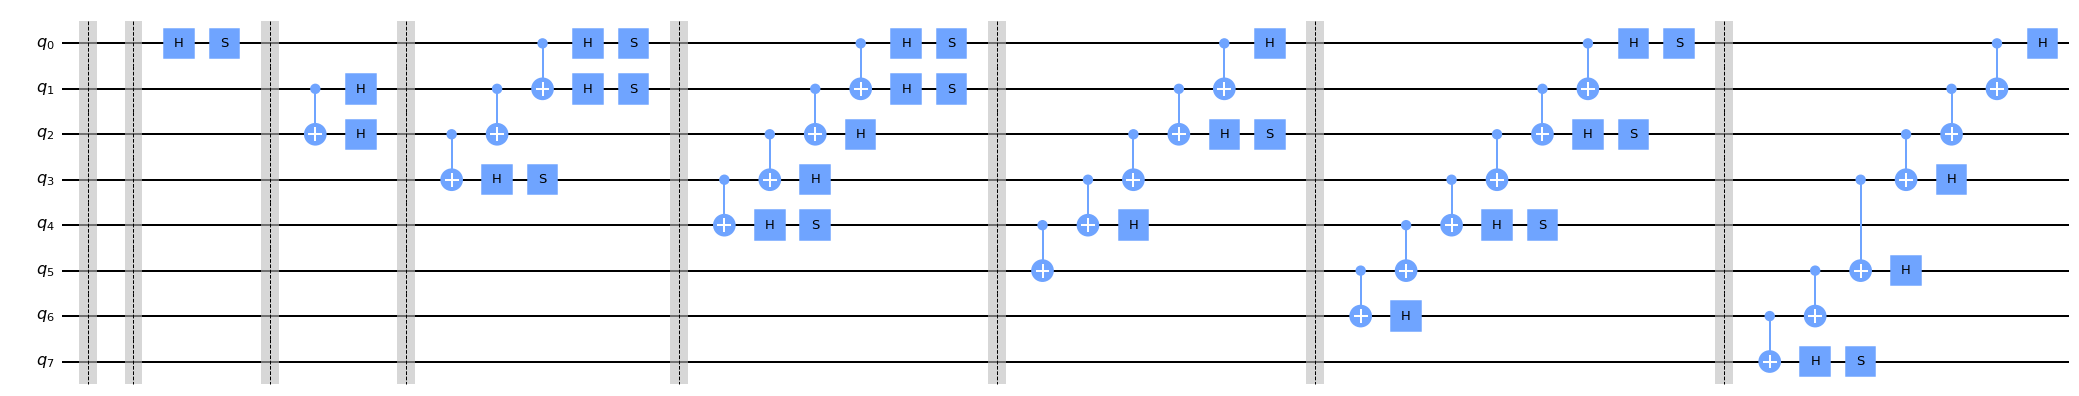

In [7]:
qc = ops_to_circuit(ops, n, barrier = True)
qc.draw('mpl', fold = -1)

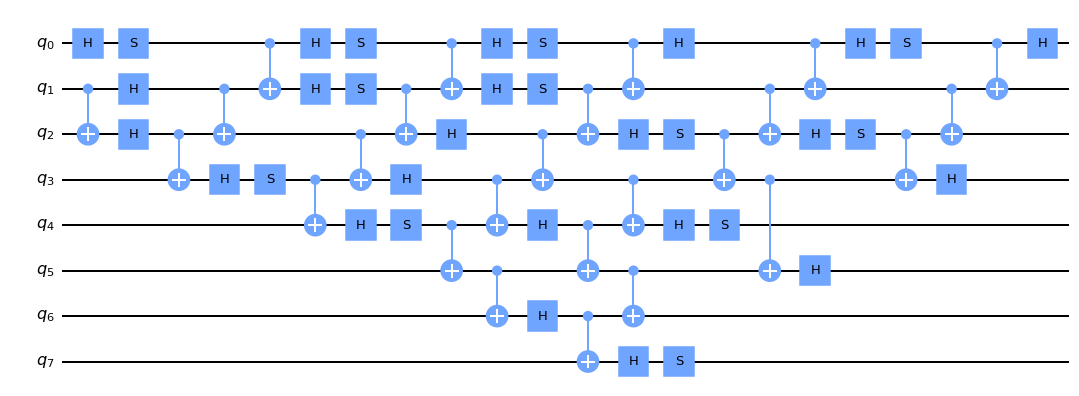

In [8]:
qc = ops_to_circuit(ops, n, barrier = False)
qc.draw('mpl', fold = -1)

In [9]:
U = Operator.from_circuit(qc).data
Udag = np.transpose(np.conjugate(U))

for p in pstringlist:
    m = Udag @ pstring_to_matrix(p) @ U
    print(p,'\t',scila.norm(m - np.diag(np.diag(m))))

['X', 'Z', 'Z', 'X', '-', 'X', 'Z', 'Y'] 	 4.440892098500622e-16
['-', 'Y', 'Z', 'X', 'X', 'X', 'X', '-'] 	 4.440892098500622e-16
['Z', 'Y', 'X', 'Y', 'Y', '-', 'Y', 'X'] 	 4.440892098500622e-16
['Y', 'Z', 'Y', 'Z', 'Z', 'Y', 'Z', '-'] 	 4.440892098500622e-16
['Z', 'X', 'X', 'Y', 'Y', '-', 'X', 'X'] 	 4.440892098500622e-16
['-', '-', 'Y', 'Z', '-', '-', '-', '-'] 	 4.440892098500622e-16
['X', '-', '-', '-', 'Y', 'Y', '-', 'Z'] 	 4.440892098500622e-16
['Z', 'Y', 'Z', 'X', '-', 'X', 'X', 'Z'] 	 4.440892098500622e-16


# k-Commutative stuff

In [10]:
def kcommutative_diagonalize(pstrings, k, n):
    #assuming that the pstrings k-commute with each other!! It might not work otherwise.

    operation_list = []
    
    for i in range(n//k):
        newlist = []
        for p in pstrings:
            newlist.append(p[i*k:(i+1)*k])
        
        newops = simultaneously_diagonalize(newlist)
        for o in newops:
            for j in range(1, len(o)):
                o[j] = o[j] + i*k
        
        operation_list += newops
        
    if n%k > 0:
        newlist = []
        for p in pstrings:
            newlist.append(p[n-(n%k):n])

        newops = simultaneously_diagonalize(newlist)
        for o in newops:
            for j in range(1, len(o)):
                o[j] = o[j] + n-(n%k)

        operation_list += newops

    return operation_list

def get_random_kclifford(n,k,count):
    list = []
    for i in range(count):
        list.append([])

    for i in range(n//k):
        newlist = get_random_clifford(k, count)
        for j in range(count):
            list[j] += newlist[j]

    if n%k > 0:
        newlist = get_random_clifford(n%k, count)
        for j in range(count):
            list[j] += newlist[j]

    return list
    

In [11]:
n = 9
k = 4
count = 10
pstringlist = get_random_kclifford(n, k, count)
for p in pstringlist:
    print(p)

['-', '-', '-', '-', 'Y', 'Y', 'Z', 'Z', '-']
['X', 'X', 'Y', 'X', '-', '-', '-', '-', '-']
['-', '-', 'Z', 'Y', 'Y', 'Y', '-', '-', 'Z']
['Z', '-', 'Y', 'Z', 'Y', '-', 'X', 'Y', '-']
['-', '-', '-', '-', 'Z', 'X', 'X', 'X', '-']
['-', '-', '-', '-', 'X', 'X', 'Z', '-', '-']
['Z', '-', 'Y', 'Z', 'Y', '-', 'Y', 'X', 'Z']
['Z', '-', 'Y', 'Z', 'Y', '-', 'Y', 'X', '-']
['Y', 'X', 'Z', '-', 'X', 'X', '-', 'Z', '-']
['Y', 'Y', 'X', 'Z', 'X', 'X', '-', 'Z', '-']


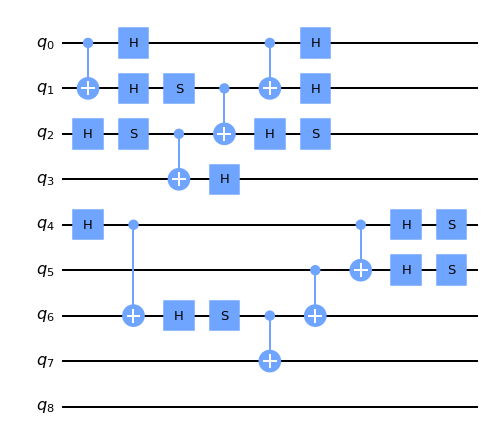

In [12]:
ops = kcommutative_diagonalize(pstringlist, k, n)
qc = ops_to_circuit(ops, n)
qc.draw('mpl', fold = -1)

In [13]:
ops

[['H', 0],
 ['H', 1],
 ['Sdag', 2],
 ['H', 2],
 ['H', 3],
 ['CX', 0, 1],
 ['CX', 1, 2],
 ['CX', 2, 3],
 ['Sdag', 2],
 ['H', 2],
 ['H', 0],
 ['Sdag', 1],
 ['H', 1],
 ['CX', 0, 1],
 ['Sdag', 4],
 ['H', 4],
 ['Sdag', 5],
 ['H', 5],
 ['CX', 4, 5],
 ['CX', 5, 6],
 ['CX', 6, 7],
 ['Sdag', 6],
 ['H', 6],
 ['CX', 4, 6],
 ['H', 4]]

In [54]:
for p in pstringlist:
    result, change = apply_ops(ops, p)
    print(result, change)

['-', '-', '-', 'Z', '-', '-', 'Z', '-', '-'] False
['-', 'Z', '-', 'Z', '-', '-', '-', 'Z', 'Z'] False
['Z', 'Z', '-', '-', '-', '-', '-', '-', '-'] False
['-', '-', 'Z', 'Z', '-', 'Z', 'Z', '-', 'Z'] True
['Z', 'Z', '-', 'Z', '-', 'Z', 'Z', 'Z', 'Z'] True
['Z', '-', '-', 'Z', '-', '-', '-', '-', '-'] False
['Z', 'Z', 'Z', 'Z', '-', '-', 'Z', '-', 'Z'] False
['-', 'Z', '-', '-', 'Z', 'Z', '-', 'Z', '-'] True
['-', 'Z', '-', '-', '-', '-', '-', '-', '-'] False
['-', 'Z', 'Z', '-', '-', 'Z', 'Z', '-', 'Z'] True


In [56]:
U = Operator.from_circuit(qc).data
Udag = np.transpose(np.conjugate(U))

for p in pstringlist:
    m = Udag @ pstring_to_matrix(p) @ U
    print(p,'\t',scila.norm(m - np.diag(np.diag(m))))

['X', 'Z', 'Y', 'Y', '-', '-', 'X', '-', '-'] 	 4.684215712018836e-15
['-', 'X', 'X', 'Y', 'Z', 'X', 'X', 'X', 'Y'] 	 4.684215712018836e-15
['-', 'Y', 'Z', '-', '-', '-', '-', '-', '-'] 	 4.684215712018836e-15
['X', 'Y', 'Z', 'Y', 'X', 'X', 'X', 'Z', 'Y'] 	 4.684215712018836e-15
['X', 'X', 'X', 'Y', 'Y', '-', '-', 'Y', 'Y'] 	 4.684215712018836e-15
['-', 'Z', 'Y', 'Y', '-', '-', '-', '-', '-'] 	 4.684215712018836e-15
['X', '-', '-', 'Y', '-', '-', 'X', '-', 'Y'] 	 4.684215712018836e-15
['X', 'Y', 'Z', '-', '-', 'Y', 'X', 'Y', '-'] 	 4.684215712018836e-15
['X', 'Y', 'Z', '-', '-', '-', '-', '-', '-'] 	 4.684215712018836e-15
['X', 'Z', 'Y', '-', 'X', 'X', 'X', 'Z', 'Y'] 	 4.684215712018836e-15
